In [1]:
import sparse


import subprocess
import shlex
import pandas as pd
import numpy as np

import glob
import os
import wget
import requests
import glob
import time
import dask
import h5py

from Bio import SeqIO
import pickle
import sys
sys.setrecursionlimit( 10 **9 )
from sklearn.cluster import *
from sklearn.metrics import roc_curve , precision_recall_curve , auc

import scipy
import copy
from numpy import linalg as LA
from matplotlib import pyplot as plt
import random
import h5py
import itertools
import dendropy
import os
import psutil
import seaborn as sns


overwrite = False
jk_iterations = 5
os.environ['MKL_ENABLE_INSTRUCTIONS'] = 'AVX2'

In [2]:
import torch
#create graphs on the fly to represent pairs of profiles
device = torch.device('cuda' )
#device = torch.device('cpu')
print(device)

/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [3]:
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import ChebConv
from torch_geometric.nn import  to_hetero
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.data import HeteroData ,InMemoryDataset
import copy
import time
import pickle
import random

In [4]:
filedir = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/'

In [5]:

files = glob.glob( '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/apr_4_2022/mmsa_2022-04-04/2022-04-04_masked.fa_02022-06-14T07:53:44.200443small_test_coevmats.pkl')
print(files)

['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/apr_4_2022/mmsa_2022-04-04/2022-04-04_masked.fa_02022-06-14T07:53:44.200443small_test_coevmats.pkl']


In [6]:
#treefile = '../validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.aln.EPIID.treefile'
#alnfile = '../validation_data/covid19/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.aln'
alnfile = filedir + 'datasets/covid_data/msa_0730/msa_0730.fasta'

treefile = '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/feb_2021/GISAID-hCoV-19-phylogeny-2021-02-21/global.tree'
modeldir = filedir+'datasets/covid_data/structs/'

alnh5 = alnfile+'.h5'
#ts = '2021-08-08T11:16:34.358764'
#ts = '2021-08-08T14:37:59.736512'
#events = alnfile+'*'+ts+'*'
eventmats = files

In [7]:
with open(treefile) as treelines:
    print( next(treelines)[0:1000])

(EPI_ISL_406801:0,(EPI_ISL_413691:0.0,EPI_ISL_414663:0.0,EPI_ISL_414691:0.0,EPI_ISL_414690:0.0,EPI_ISL_414689:0.0,EPI_ISL_413729:0.0,EPI_ISL_413750:0.0,EPI_ISL_413746:0.0,EPI_ISL_413748:0.0,EPI_ISL_428470:0.0,EPI_ISL_428471:0.0,EPI_ISL_428476:0.0,EPI_ISL_429854:0.0,EPI_ISL_429091:0.0,EPI_ISL_429090:0.0,EPI_ISL_429093:0.0,EPI_ISL_429092:0.0,EPI_ISL_429075:0.0,EPI_ISL_429082:0.0,EPI_ISL_429084:0.0,EPI_ISL_429083:0.0,EPI_ISL_407893:0.0,EPI_ISL_416326:0.0,EPI_ISL_416352:0.0,EPI_ISL_407976:0.0,EPI_ISL_411926:0.0,EPI_ISL_421246:0.0,EPI_ISL_421244:0.0,EPI_ISL_421242:0.0,EPI_ISL_421240:0.0,EPI_ISL_421237:0.0,EPI_ISL_421249:0.0,EPI_ISL_421247:0.0,EPI_ISL_412979:0.0,EPI_ISL_408480:0.0,EPI_ISL_449481:0.0,EPI_ISL_449484:0.0,EPI_ISL_451384:0.0,EPI_ISL_457687:0.0,EPI_ISL_457688:0.0,EPI_ISL_457689:0.0,EPI_ISL_457690:0.0,EPI_ISL_457692:0.0,EPI_ISL_457693:0.0,EPI_ISL_457695:0.0,EPI_ISL_457696:0.0,(EPI_ISL_463895:5e-09,((EPI_ISL_537438:0.000134997,(((EPI_ISL_412982:0.00010032,(((EPI_ISL_428674:3.3427e-0

In [8]:
tree = dendropy.Tree.get( path=treefile, schema='newick' )

In [9]:
#setup the internal nodes for the fitch algo
for i,l in enumerate(tree.nodes()):
    l.event = {}
    l.scores = {}
    l.symbols = None
    l.char= None
    l.matrow = i
    

In [10]:
import networkx as nx
import colour
#quick and dirty check of trees

def tree_circle(node, start , sliver  ):
    if start == True :
        global count
        count = 0
    for i,child in enumerate(node.child_nodes()):
        if child.is_leaf() == True:
            child.radians = count*sliver
            count+=1
        if child.radians is None and child.is_leaf() == False :
            tree_circle( child , start = False , sliver = sliver  )
    radians = np.mean([ child.radians if child.radians else 0 for child in node.child_nodes() ])
    if node.radians is None:
        node.radians = radians

def phylograph(treein,labels , title = None):
    N = len(treein.nodes())
    tree = copy.deepcopy(treein)
    pdm = tree.phylogenetic_distance_matrix()
    sliver = 2*np.pi / len(tree.leaf_nodes())
    
    root = tree.seed_node
    radii = [ n.distance_from_root() for n in tree.nodes()]
    for n in tree.nodes():
        n.radians = None
    tree_circle(tree.seed_node, start=True , sliver = sliver)
    thetas = [n.radians for n in tree.nodes() ]
    pos = { i: [ np.sin(thetas[i])*radii[i] , np.cos(thetas[i])*radii[i]] for i in range(len(thetas)) }
    index = np.vstack([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
    connectmat = np.zeros(( N ,  N ) )
    connectmat[index[:,0],index[:,1]] = 1 
    connectmat += connectmat.T
    G = nx.from_numpy_array(connectmat)
    red = colour.Color("red")
    blue = colour.Color("blue")
    crange = dict( zip ( list(set(labels)),  [ c.hex_l for c in list(red.range_to(blue, len(set(labels)) ) ) ] ) )
    colors = [crange[n] for n in labels ]
    #color according to downstream node
    edge_colors= [crange[labels[v]] for u,v in G.edges() ]
    #node size inversly proportional to number in graph
    plt.figure(figsize= (20,20) )
    if title:
        plt.title(title)
    nx.draw_networkx(G, pos = pos,  node_color = colors , node_size = 5, width = .5 , edge_color = edge_colors , with_labels=False)
    plt.show()

In [11]:
def ROC_curve(y_data, label = None):
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], 'k--')
    for l in y_data:
        print(l)
        y_pred_grd = y_data[l]['Ytrue']
        y_test = y_data[l]['Ypred']
        fpr, tpr, _ = roc_curve(   y_pred_grd ,y_test)
        plt.plot(fpr, tpr, label=l + 'auc'+ str(auc(fpr, tpr) ))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    if label:
        plt.savefig( label +'_ROC.svg' )
    plt.show()
    
    
    plt.figure(figsize=(10,10))
    for l in y_data:
        y_pred_grd = y_data[l]['Ytrue']
        y_test = y_data[l]['Ypred']
        precision, recall, thresholds = precision_recall_curve( y_pred_grd, y_test)
        plt.plot( recall, precision , label= l )
        plt.ylabel('Precision')
        plt.xlabel('Recall')
    
    plt.title('PR curve')
    plt.legend(loc='best')
    if label:
        plt.savefig( label +'_PR.svg' )
    plt.show()
    
def ROC_curve_single(y_test, y_pred_grd):
    fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

    plt.plot([0, 1], [0, 1], 'k--')

    fpr, tpr, _ = roc_curve(y_test, y_pred_grd)
    plt.plot(fpr, tpr, label='single')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    precision, recall, thresholds = precision_recall_curve(  y_test , y_pred_grd)
    plt.plot(precision, recall , label='single')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

    plt.title('PR curve')
    plt.legend(loc='best')
    plt.show()


In [12]:
print( eventmats )

['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/apr_4_2022/mmsa_2022-04-04/2022-04-04_masked.fa_02022-06-14T07:53:44.200443small_test_coevmats.pkl']


In [13]:

if os.path.exists( alnfile + '_IDs.pkl'):
    with open( alnfile + '_IDs.pkl' , 'rb') as idxin:
        IDindex = pickle.loads(idxin.read())
    IDs = dict(zip( IDindex.values() , IDindex.keys() ) )
else:
    
    msa = SeqIO.parse(alnfile , format = 'fasta')
    def clipID(ID):
        return ''.join( [ s +'|' for s in str(ID).split('|')[:-1] ])[:-1].replace('_',' ') 
    IDs = {i:rec.id for i,rec in enumerate(msa)}
    IDindex = dict(zip( IDs.values() , IDs.keys() ) )
    print( [(t,IDindex[t]) for t in list(IDindex.keys())[0:10]] )
    with open( alnfile + '_IDs.pkl' , 'wb') as idxout:
        idxout.write(pickle.dumps(IDindex))

In [14]:
print(len(IDindex))

2212775


In [15]:
models = '7DZW, 6vxx,6zxn,5x58,6cs0,6sc1,6nb6, 2jw8, 2xab, 4aud1, 1yo4, 2acf, 2wct, 3vc8, 2gt7, 3ee7, 2g9t, 3ee7, 2g9t, 6jyt, 1ysy, 6nur, 2g9t, 5c8u, 2g9t, 2xyq, 4mm3, 6cs2, 6acg, 6acj, 6ack, 2dd8, 2ghw, 6nb6, 6nb7'
#models = '6vxx,6zxn'
models = models.split(',')

from Bio.PDB import *
dl_url = 'http://files.rcsb.org/download/'
dl_url_err = 'http://files.rcsb.org/download/'

structs = {}
already = glob.glob( modeldir+'/*.pdb' )
print(already)
#pull complexes
for m in models:
    structfile = modeldir+m.upper().strip()+'.pdb'
    if structfile not in already:
        print(m)
        time.sleep(1)
        try:
            wget.download(url = dl_url + m.strip() +'.pdb' , out =structfile)
            structs[m] = structfile
        except:
            try:
                wget.download(url = dl_url + m.strip() +'.pdb' , out =structfile)
                structs[m] = structfile
            except:
                print('err', m )
    else:
        structs[m.strip()] = structfile


['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NB7.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/3EE7.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2ACF.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2JW8.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YO4.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6CS0.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6JYT.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2XAB.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NUR.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/5C8U.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YSY.pdb', '/work/FAC/FBM/DBC/cdess

In [16]:
modelfiles = modeldir + '*.pdb'
modelfiles = glob.glob( modelfiles )
print(modelfiles)

['/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NB7.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/3EE7.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2ACF.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2JW8.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YO4.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6CS0.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6JYT.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2XAB.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NUR.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/5C8U.pdb', '/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YSY.pdb', '/work/FAC/FBM/DBC/cdess

In [17]:
from Bio.PDB import MMCIFParser, PDBParser , PDBIO
from Bio.PDB.mmcifio import MMCIFIO
parser = PDBParser()
import warnings
from Bio import SeqUtils

###compile all pdbs to fasta 
converter = SeqUtils.IUPACData.protein_letters_3to1
converter = { res.upper():converter[res] for res in converter}
chain_sequences={}
for model in modelfiles:
    print(model)
    with warnings.catch_warnings():
        try:
            m = model.split('/')[-1].replace('pdb' , '') 
            warnings.simplefilter("ignore")
            structure = parser.get_structure(m, model)
            io=PDBIO()
            io.set_structure(structure)
            chain_sequences[model]= { c.id : ''.join(  [ converter[ r.get_resname()] for r in c.get_residues() if 'CA' in r ] ) for c in structure.get_chains() }
            chain_sequences[model]={ c: chain_sequences[model][c] for c in chain_sequences[model] if len(chain_sequences[model][c])> 0 }
        except:
            print('err', model)

/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NB7.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/3EE7.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2ACF.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2JW8.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/1YO4.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6CS0.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta.pdb
err /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6JYT.pdb
err /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6JYT.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/2XAB.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/6NUR.pdb
/work/FAC/FBM/DBC/cdessim2/default/dmo

In [18]:
with open( modeldir + 'struct_chains.fasta', 'w') as fastout:
    for model in chain_sequences:
        for c in chain_sequences[model]:
            fastout.write( '> '+model+ ':'+c + '\n' + chain_sequences[model][c] + '\n' )

In [19]:

from dask.distributed import fire_and_forget
from dask.distributed import Client, Variable , Queue , Lock ,LocalCluster
from dask_jobqueue import SLURMCluster
from dask.distributed import  utils_perf
import dask
import dask.bag as db
import dask.array as da
import dask.dataframe as dd
from dask.delayed import delayed
from dask import delayed, compute

distributed_computation = False

print('flashing up a dask cluster')
if distributed_computation == True:
    
    NCORE = 4
    njobs = 20
    print('deploying cluster')
    cluster = SLURMCluster(
        walltime='1:00:00',
        n_workers = NCORE,
        cores=NCORE,
        processes = NCORE,
        interface='ib0',
        memory="10GB",
        env_extra=[
        'source /scratch/dmoi/miniconda/etc/profile.d/conda.sh',
        'conda activate ML'
        ],
        scheduler_options={'interface': 'ens3f0' }
    )
    print(cluster.job_script())
    cluster.adapt(minimum=10, maximum=100)
    time.sleep(5)

    print(cluster)
    print(cluster.dashboard_link)
    client = Client(cluster , timeout='450s' , set_as_default=True )
else:
    if __name__ == '__main__':
        NCORE = 10
        njobs = 1
        print('testing')
        cluster = LocalCluster(n_workers = NCORE )    
        print(cluster.dashboard_link)
        client = Client(cluster)
print('done')

/users/dmoi/.local/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


flashing up a dask cluster
testing
http://127.0.0.1:8787/status
done


In [20]:
nucleotide_mutation = None
AA_mutation = None
for mat in eventmats:
    with open( mat , 'rb') as pklin:
        mats = pickle.loads(pklin.read())
        print(mats)
        if AA_mutation is None:
            nucleotide_mutation = mats[1]
            AA_mutation = mats[0]
        else:
            nucleotide_mutation += mats[1]
            AA_mutation += mats[0]
print(nucleotide_mutation)
print(AA_mutation)

(<COO: shape=(741326, 29891, 380), dtype=float64, nnz=93228, fill_value=0.0>, <COO: shape=(741326, 29891, 12), dtype=float64, nnz=156073, fill_value=0.0>)
<COO: shape=(741326, 29891, 12), dtype=float64, nnz=156073, fill_value=0.0>
<COO: shape=(741326, 29891, 380), dtype=float64, nnz=93228, fill_value=0.0>


In [21]:
mat_cleanup = True
from scipy.stats import gamma

AAmat = AA_mutation.sum(axis = 2).to_scipy_sparse()

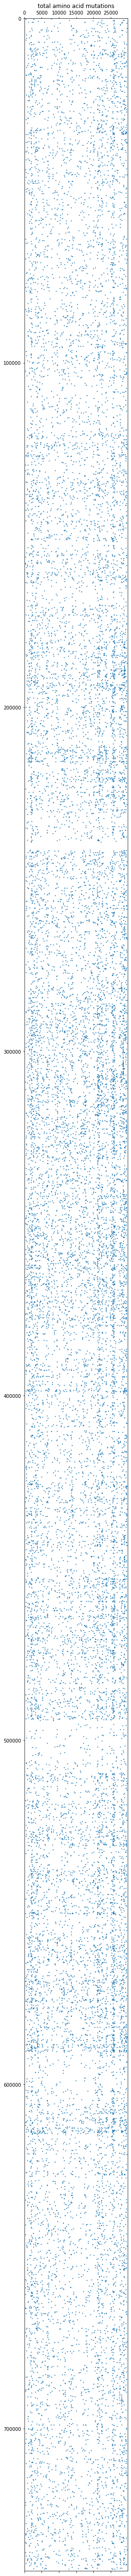

In [22]:
plt.figure(figsize=(10,100))
plt.spy(AAmat, markersize= .5)
plt.title('total amino acid mutations')
plt.show()

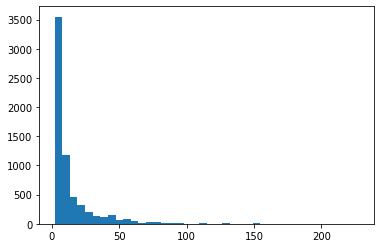

In [23]:
colsum = AAmat.sum(axis = 0)
colsum = colsum[colsum>1]
#colsum = colsum[colsum<100]

plt.hist(colsum.flat , bins = 40)
plt.show()

In [24]:
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)


2685.46484375


In [25]:
allowed_symbols = [ b'A', b'C', b'G' , b'T' ]
allowed_transitions = [ c1+c2 for c1 in allowed_symbols for c2 in allowed_symbols  if c1!= c2]
print('allowed transitions',allowed_transitions)

transition_dict = {  c : i  for i,c in enumerate( allowed_transitions )  }
rev_transition_dict= dict( zip(transition_dict.values(), transition_dict.keys()))
allowed_symbols = set(allowed_symbols)

print('transition dict', transition_dict)
ProteinAlphabet = [ 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y' ]
allowed_AA_transitions = [ c1+c2 for c1 in ProteinAlphabet for c2 in ProteinAlphabet  if c1!= c2]
transitiondict_AA = {  c : i  for i,c in enumerate( allowed_AA_transitions )  }
rev_transitiondict_AA = dict( zip(transitiondict_AA.values(), transitiondict_AA.keys()))


allowed transitions [b'AC', b'AG', b'AT', b'CA', b'CG', b'CT', b'GA', b'GC', b'GT', b'TA', b'TC', b'TG']
transition dict {b'AC': 0, b'AG': 1, b'AT': 2, b'CA': 3, b'CG': 4, b'CT': 5, b'GA': 6, b'GC': 7, b'GT': 8, b'TA': 9, b'TC': 10, b'TG': 11}


741326
nodes


/users/dmoi/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


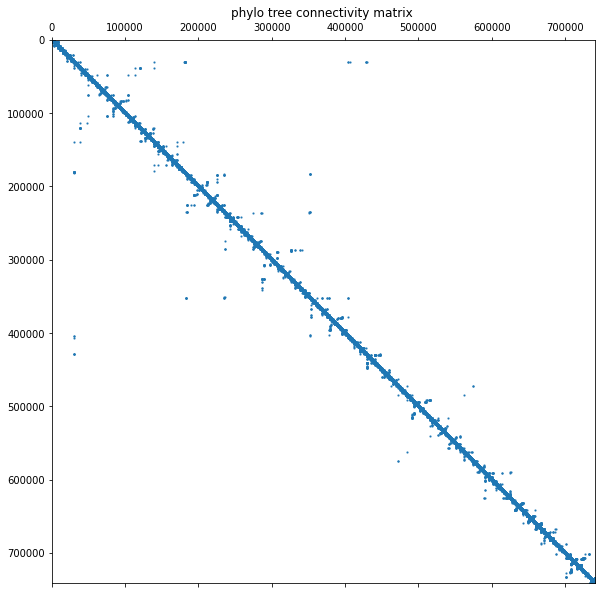

In [26]:
for i,n in enumerate(tree.nodes()):
    n.matrow = i
    n.symbols = None
    n.scores = None
    n.event = None
    n.char = None

matsize = len(tree.nodes())
print(matsize)
print('nodes')
#blur w connectivity mat
blurfactor =  .25
connectmat = scipy.sparse.csc_matrix((len(tree.nodes()), len(tree.nodes() ) ) )
index = np.array([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
lengths = np.array([ c.edge_length for n in tree.nodes() for c in n.child_nodes()])
total_len = np.sum(lengths)
#fill diagonal
#index = np.vstack( [index , np.array([ [n.matrow, n.matrow ] for n in tree.nodes() ]) ] )

connectmat[index[:,0],index[:,1]] = 1
connectmat[index[:,1],index[:,0]] = 1


#connectmat = connectmat.todense()
diag = [ i for i in range(connectmat.shape[0])]
connectmat[diag,diag] = 1
#connectmat = connectmat.todense()
#connectmat = scipy.sparse.csc_matrix(connectmat)
#np.fill_diagonal(connectmat , 1)
connectmat = scipy.sparse.coo_matrix(connectmat)
plt.figure( figsize=(10,10))
plt.title( 'phylo tree connectivity matrix ' )
plt.spy(connectmat, markersize= 1)
plt.show()

In [27]:
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)


2379.44140625


In [28]:
#####define the aln row and structure here, for dengue they should all be the same
selected_strain = list(IDindex.keys())[100]
import dask.array as da
with h5py.File(alnh5, 'r') as hf:
    align_array = hf['MSA2array']
    print(IDindex[selected_strain])
    print(selected_strain)
    #filter to columns without gaps
    non_gap = np.where( align_array[: , IDindex[selected_strain]] != b'-')[0]
    print(non_gap)
    print(non_gap.shape)
    sequence = align_array[ non_gap , IDindex[selected_strain]]
    print(np.unique(sequence))

100
EPI ISL 2874801
[  162   163   164 ... 40398 40399 40400]
(29809,)
[b'A' b'C' b'G' b'K' b'N' b'T']


In [29]:
#find the amino acid chains in the structs
import subprocess
import shlex

with open( alnfile + 'refgeno.fasta' , 'w' ) as fastout:
    fastout.write('>'+selected_strain + '\n')
    fastout.write( ''.join( c.decode() for c in list(sequence) ) + '\n' )
qfile =  alnfile + 'refgeno.fasta'

In [30]:
blastpath = filedir + 'software/ncbi-blast-2.11.0+-src/c++/ReleaseMT/bin/'
print(modeldir + 'covid_structs.fasta')
def runblastx( qseq , blastpath = blastpath , outannot = alnfile+'struct_blastout.txt' , db = modeldir + 'struct_chains.fasta' , outfmt = None ):
    if outfmt is None:
        outfmt = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ]
        outfmt =  ' "10 ' + ''.join([fmt+ ' ' for fmt in outfmt]) + ' " '
        print(outfmt)
    args = blastpath+'blastx -query '+ qfile + ' -db '+db+' -outfmt' + outfmt + ' -out ' + outannot  
    print(args)
    p = subprocess.run( shlex.split(args) )
    return p , outannot

p,annot = runblastx(qfile)
print(annot)

/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/covid_structs.fasta
 "10 qseqid sseqid qlen slen qstart qend qframe evalue  " 
/work/FAC/FBM/DBC/cdessim2/default/dmoi/software/ncbi-blast-2.11.0+-src/c++/ReleaseMT/bin/blastx -query /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fastarefgeno.fasta -db /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/structs/struct_chains.fasta -outfmt "10 qseqid sseqid qlen slen qstart qend qframe evalue  "  -out /work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fastastruct_blastout.txt
/work/FAC/FBM/DBC/cdessim2/default/dmoi/datasets/covid_data/msa_0730/msa_0730.fastastruct_blastout.txt


In [31]:
annotation = pd.read_csv(  annot , header = None )
annotation.columns = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ] 
annotation = annotation[ annotation['evalue'] < 10**-3 ]

annotation['struct'] = annotation.sseqid.map( lambda x : x.split(':')[0].split('/')[-1].replace('.pdb','') )
annotation['chain'] = annotation.sseqid.map( lambda x : x.split(':')[1] )
annotation.to_csv( alnfile +'struct_annotation.csv'  )
print(annotation)
#make annotation for dengue orfs
#find equivalent structures in multimers

   qseqid                                             sseqid   qlen  slen  \
0     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
1     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
2     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
3     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1060   
4     EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1054   
..    ...                                                ...    ...   ...   
88    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    87   
89    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    85   
90    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    85   
91    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    81   
92    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809    70   

    qstart   qend  qframe        evalue struct chain  
0    21604  24966   

In [32]:
chainlen = dict( zip ( annotation.struct + annotation.chain , annotation.slen ))

In [33]:
filter_annot = True
if filter_annot == True:
    annotation = annotation[annotation.struct == '7DZW']

In [34]:
print(annotation)

  qseqid                                             sseqid   qlen  slen  \
0    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
1    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   
2    EPI  /work/FAC/FBM/DBC/cdessim2/default/dmoi/datase...  29809  1121   

   qstart   qend  qframe  evalue struct chain  
0   21604  24966       1     0.0   7DZW     C  
1   21604  24966       1     0.0   7DZW     B  
2   21604  24966       1     0.0   7DZW     A  


In [35]:
#grab AA chain residues
import itertools
import warnings
distmats = {}
overwrite_connect = True
@dask.delayed()
def retmat_single(totalatoms, chain, slen= None):
    ret = np.array( [[ a1['CA'] - a2['CA']  for i,a1 in enumerate(totalatoms[chain])  ] for j,a2 in enumerate(totalatoms[chain]) ] )
    if slen:
        ret = ret[:slen]
        ret = ret[:,:slen]
    return ret
    
@dask.delayed()
def retmat_double(totalatoms, chain1, chain2 , slen1= None , slen2 = None):
    ret = np.array( [[ a1['CA'] - a2['CA'] for i,a1 in enumerate(totalatoms[chain1])] for j,a2 in enumerate(totalatoms[chain2]) ] )
    if slen1:
        ret = ret[:slen1]
    if slen2:
        ret = ret[:,:slen2]
    return ret

@dask.delayed()
def addT(arr):
    arr += arr.T

if overwrite_connect == True:
    totalatoms = {}
    for i,model in enumerate(annotation.sseqid.unique()):
        with warnings.catch_warnings():
            m = model.split('/')[-1].replace('.pdb' , '').split(':')[0]
            print(m)
            
            warnings.simplefilter("ignore")
            structure = parser.get_structure(m, model.split(':')[0])
            io=PDBIO()
            io.set_structure(structure)
            totalatoms.update( { c.id : [ r for r in c.get_residues() if 'CA'  in r ] for c in structure.get_chains() } )
    for chain in totalatoms:
        print(structure)
        if model not in distmats:
            distmats[m]= {}
            #if m+chain in chainlen:
            #    l1 = chainlen[m+chain]    
        l1 = None
        distmats[m][chain] = retmat_single( totalatoms, chain , l1 )
            #get interchain dists
    combocount = 0
    for chain1,chain2 in itertools.combinations(totalatoms,2):
        if combocount < 2:
            l1 = None
            #if m+chain1 in chainlen:
            #    l1 = chainlen[m+chain1]
            l2 = None
            #if m+chain2 in chainlen:
            #    l2 = chainlen[m+chain2]
        else:
            break

        combocount+=1
        distmats[m][(chain1,chain2)] = retmat_double(totalatoms, chain1, chain2  ,l1 , l2)    
        #compute vals
        #    print( ' err ', m )
    if m in distmats:
        distmats[m] = dict( zip ( distmats[m].keys() , dask.compute( * list(distmats[m].values() ))))
        #distmats[m] = dict( zip ( distmats[m].keys() , dask.compute( * [dropna(a) for a in list(distmats[m].values() )] ) ) ) 


7DZW
7DZW
7DZW
<Structure id=7DZW>
<Structure id=7DZW>
<Structure id=7DZW>


In [36]:
show_distmats = False
remove =[]
if overwrite_connect == True:
    if show_distmats == True:
        for model in distmats:
            print( model )
            for i,chain in enumerate(distmats[model]):
                if distmats[model][chain].shape[0]>0:
                    if np.sum(distmats[model][chain])==0:
                        remove.append((model,chain))
                    else:
                        plt.figure(figsize= (20,20))
                        plt.title('distmat ' + model + '  '+  ''.join(chain))
                        plt.imshow(distmats[model][chain])
                        plt.show()
    for model,chain in remove:
        del distmats[model][chain]

/users/dmoi/.local/lib/python3.8/site-packages/distributed/worker.py:4798: UserWarning: Large object of size 4.79 MiB detected in task graph: 
  (array([[ 99.283554,  96.13685 ,  93.46985 , ...,  ... e=float32), 15)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


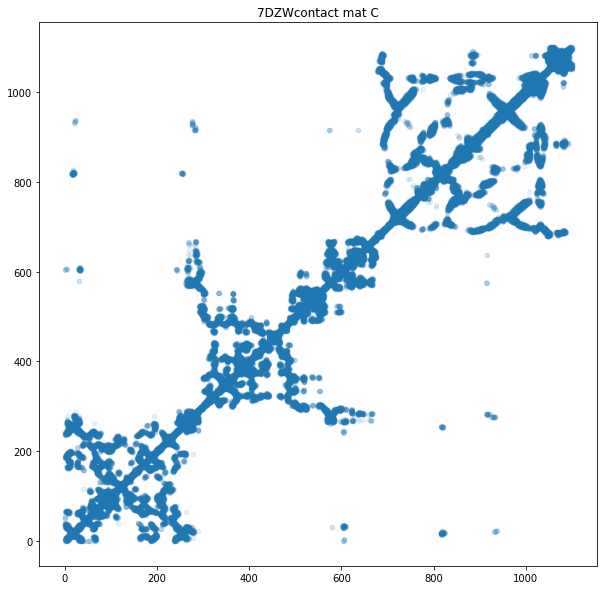

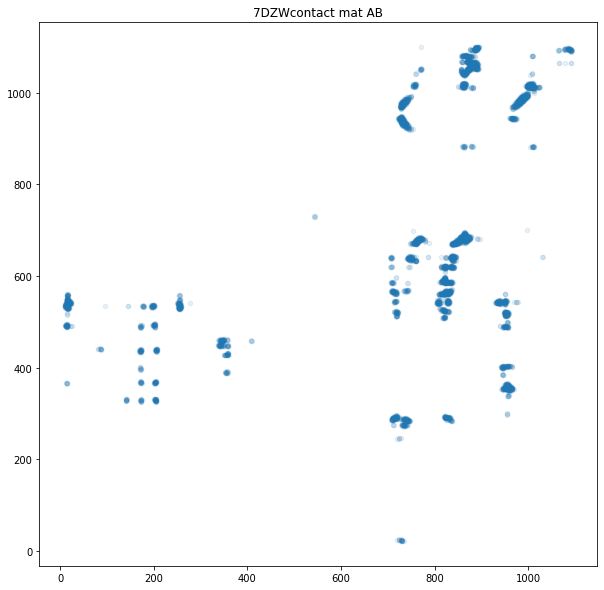

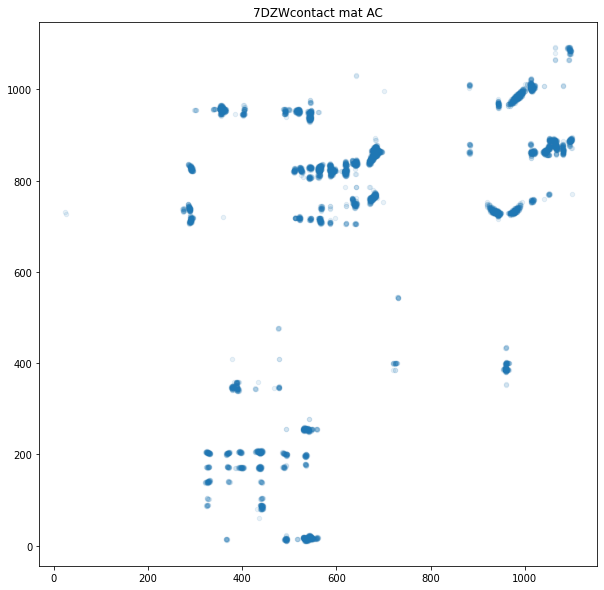

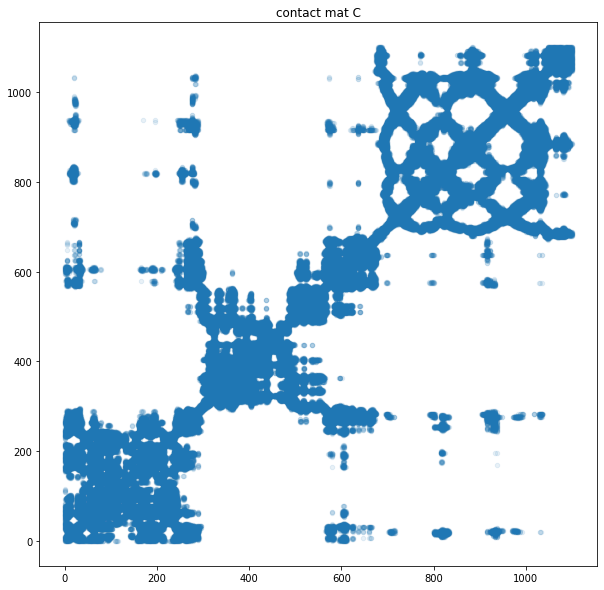

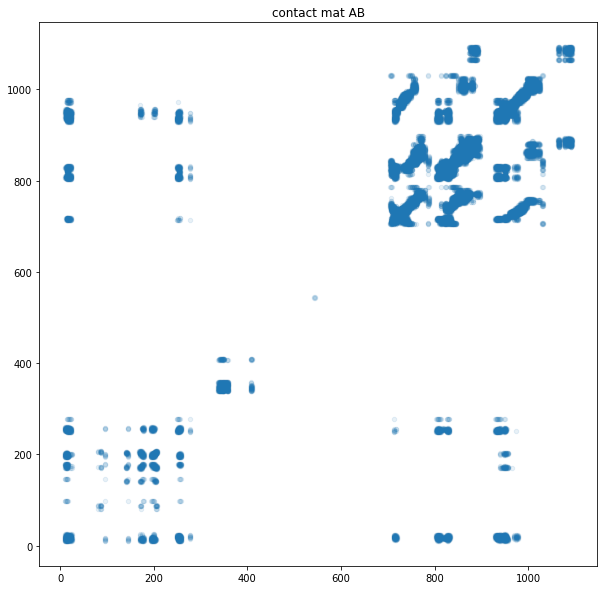

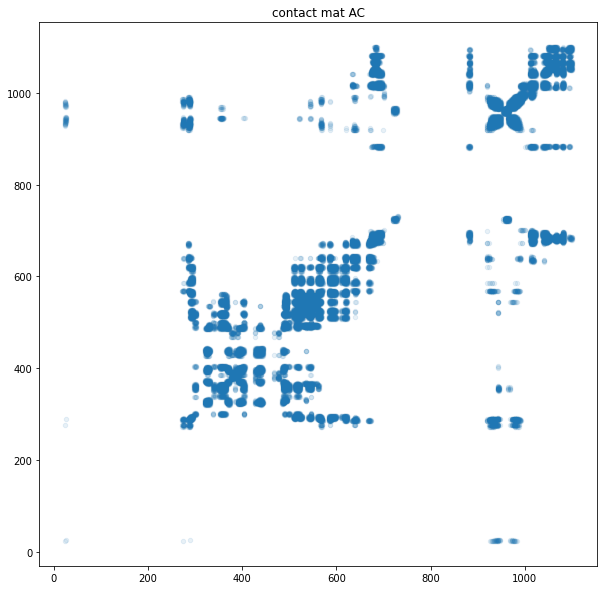

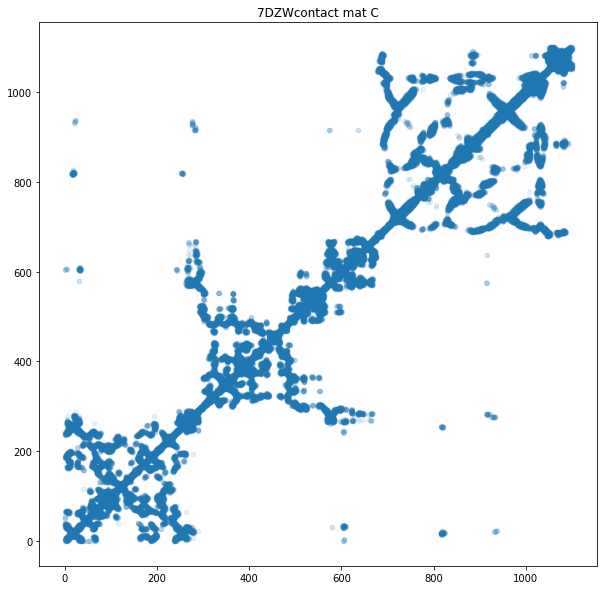

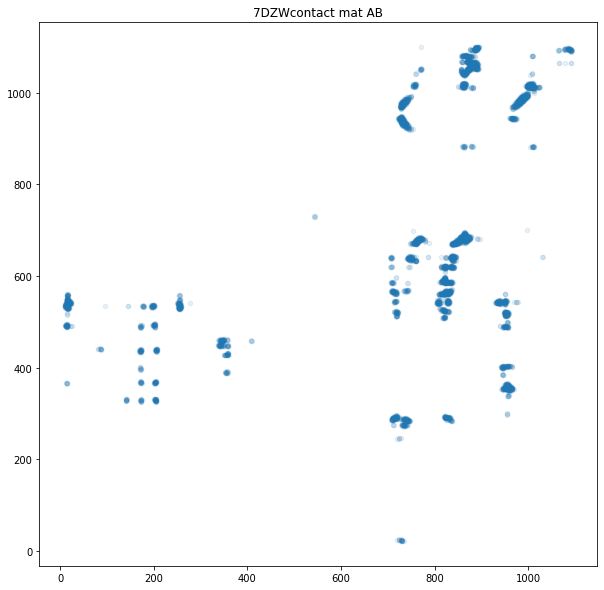

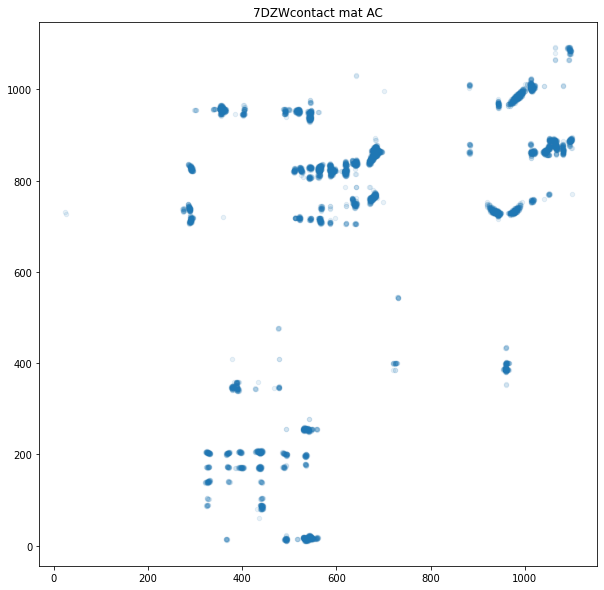

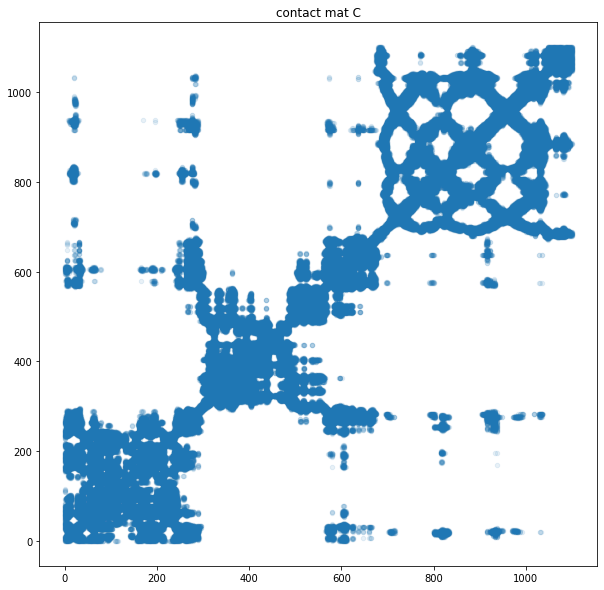

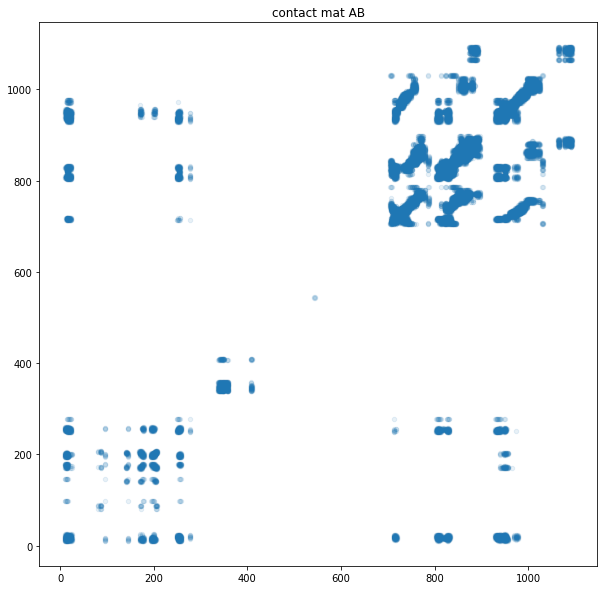

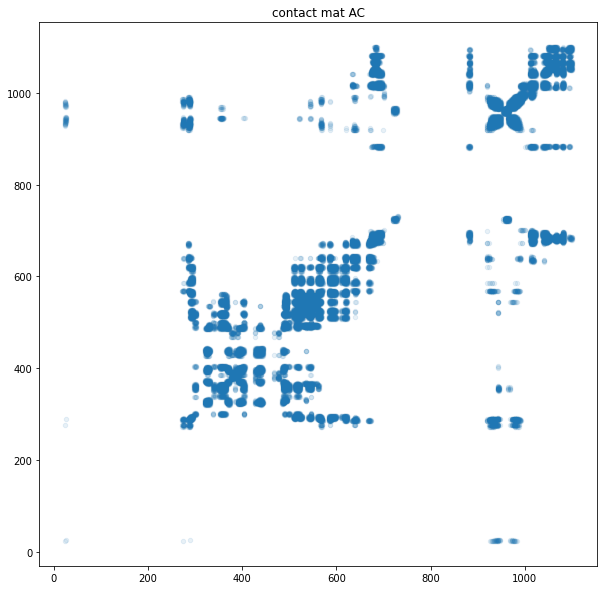

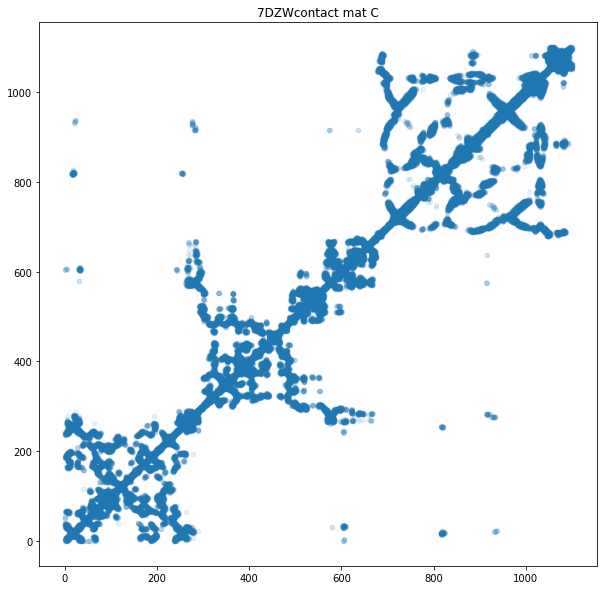

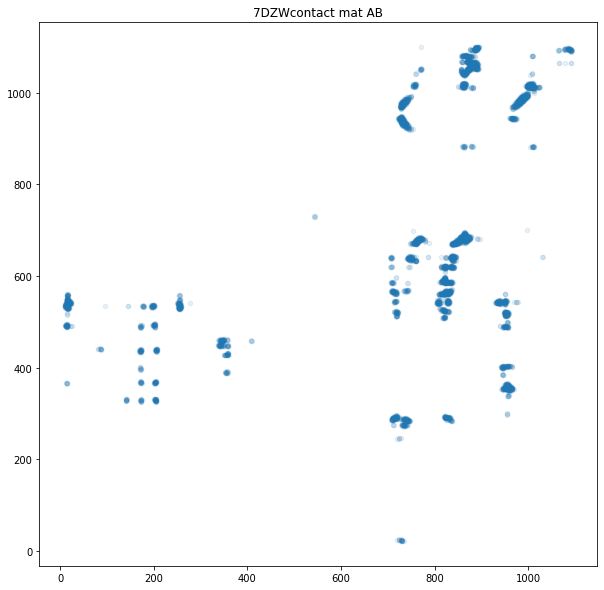

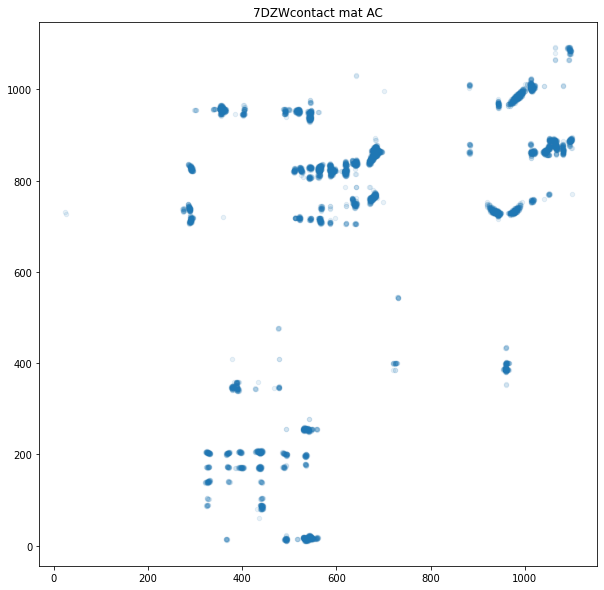

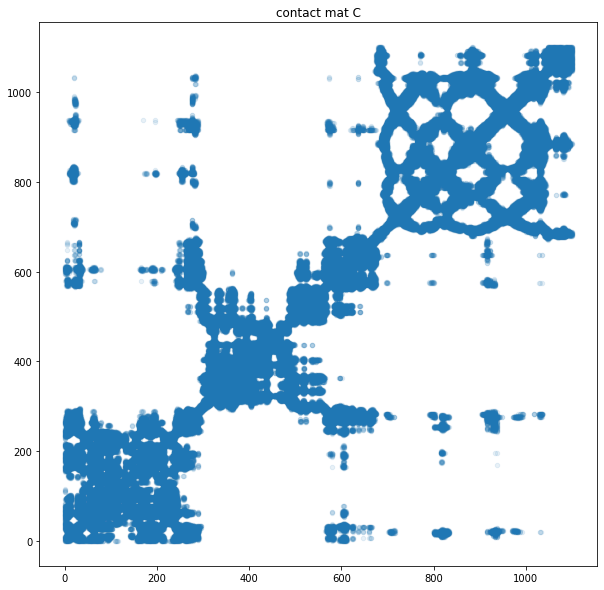

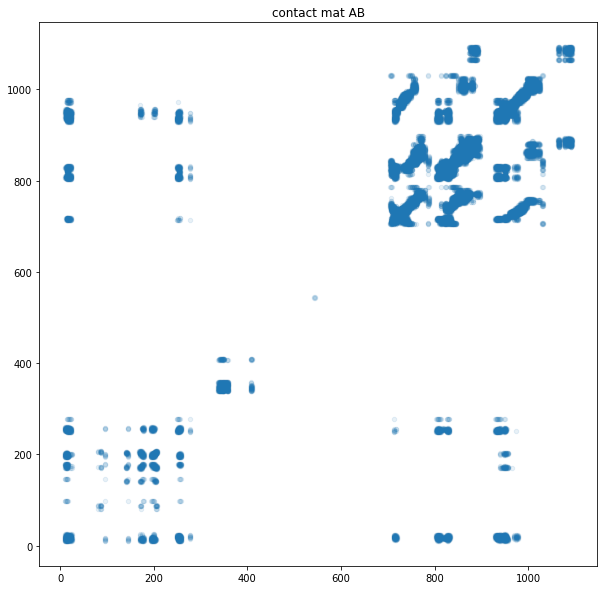

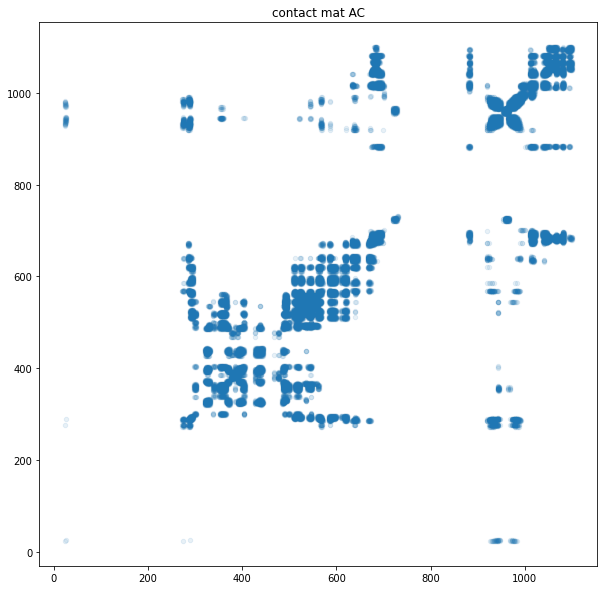

In [37]:
import copy
angstrom_cutoff = 15
show_contacts = True

if overwrite_connect == True:
    @dask.delayed( nout = 2)
    def define_contacts(mat , angstrom_cutoff = 15 ):
        subthresh = copy.deepcopy(mat)
        subthresh[ subthresh < angstrom_cutoff ] = 1 
        subthresh[ subthresh > angstrom_cutoff ] = 0 
        np.fill_diagonal(subthresh , 0)
        subthresh = subthresh[0:subthresh.shape[0]-20,0:subthresh.shape[1]-20]
        connected = np.dot(subthresh,subthresh.T)
        return subthresh,connected

    subthresh_thresh ={}
    subthresh_connected ={}

    chain_equivalencies={}
    for m in distmats:
        for chain in distmats[m]:
            if m not in subthresh_thresh:
                subthresh_thresh[m]={}
                subthresh_connected[m] ={}

                for chain in distmats[m]:
                    subthresh, connected = define_contacts(distmats[m][chain] , angstrom_cutoff  )
                    subthresh_thresh[m][chain] = subthresh
                    subthresh_connected[m][chain] = connected
            subthresh_thresh[m] = dict( zip ( subthresh_thresh[m].keys() , dask.compute( * list(subthresh_thresh[m].values() ))))
            subthresh_connected[m] = dict( zip ( subthresh_connected[m].keys() , dask.compute( * list(subthresh_connected[m].values() ))))

            if show_contacts == True:
                for chain in subthresh_thresh[m]:
                    subthresh = subthresh_thresh[m][chain]

                    plt.figure(figsize=(10,10) )
                    plt.title(m +'contact mat '+ ''.join(chain) )
                    plt.scatter( np.nonzero(subthresh)[0] ,np.nonzero(subthresh)[1]  , marker= 'o' , alpha = .1 ,  s = 20)
                    plt.show()

                for chain in subthresh_connected[m]:
                    connected = subthresh_connected[m][chain]
                    plt.figure(figsize=(10,10) )
                    plt.title('contact mat '+ ''.join(chain) )
                    plt.scatter( np.nonzero(connected)[0] ,np.nonzero(connected)[1]  , marker= 'o' , alpha = .1 ,  s = 20)
                    plt.show()

    with open(modeldir + 'contactmaps' , 'wb') as connectout:
        connectout.write(pickle.dumps((subthresh_thresh , subthresh_connected)))
else:
    with open(modeldir + 'contactmaps' , 'rb') as connectout:
        subthresh_thresh , subthresh_connected = pickle.loads(connectout.read())

In [38]:
#minhash all event cols with more than #nthresh events
#search top 10 for each col
allpairs = {}

print(subthresh_thresh)
print(subthresh_connected)

for code in subthresh_thresh:
    if code not in allpairs:
        allpairs[code] = {}
    for chainpair in subthresh_thresh[code]:
        pairs = np.nonzero(subthresh_thresh[code][chainpair])
        pairset = set([ ( pairs[0][i] , pairs[1][i] ) for i in range(pairs[0].shape[0]) ])
        
        allpairs[code][chainpair] = pairset

{'7DZW': {'C': array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]], dtype=float32), ('A', 'B'): array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), ('A', 'C'): array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}}
{'7DZW': {'C': array([[28., 19., 19., ...,  0.,  0.,  0.],
       [19., 34., 31., ...,  0.,  0.,  0.],
       [19., 31., 39., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., 19

In [39]:
def tree2Single_sparse_graph_updown(tree):
    N = len(tree.nodes())
    #mimic the fitch algo
    #propagate up and down in separate graphs
    index_up = np.vstack([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
    index_down = np.vstack([ [c.matrow, n.matrow ] for n in tree.nodes() for c in n.child_nodes()])
    
    
    
    connectmat_up = scipy.sparse.lil_matrix(( N ,  N ) )
    
    connectmat_down = scipy.sparse.lil_matrix(( N ,  N ) )
    connectmat_up[index_up[:,0],index_up[:,1]] = 1 
    
    
    connectmat_down[index_down[:,0],index_down[:,1]] = 1 
    diag = [[n,n] for n in range(N)]
    connectmat_diag=scipy.sparse.lil_matrix(( N ,  N ) )
    connectmat_diag[diag,diag] = 1 
    
    ntime = np.array([ n.distance_from_root() for n in tree.nodes()])
    mtime = np.amax(ntime)
    
    ntime/=mtime
    levels = np.array([ n.level() for n in tree.nodes() ] , dtype='double')
    mlevel = np.amax(levels)
    levels/=mlevel
    
    
    
    edgelens= np.array([ n.edge_length for n in tree.nodes() ] , dtype='double')
    
    
    template_features = np.stack([ntime ,  edgelens , levels ]).T    
    
    return connectmat_up, connectmat_down, connectmat_diag, template_features

def sparse2pairs(sparsemat, matrows = None):
    if matrows :
        sparsemat = sparsemat[matrows,:]
        sparsemat = sparsemat[:,matrows]
    sparsemat = scipy.sparse.find(sparsemat)
    return np.vstack([sparsemat[0],sparsemat[1]])



In [40]:
#tree sector based aggregation
#label sectors

def process_node_down(node, sector = 0, breakpt = 10 , total = 0 ):
    node.sector = sector
    if sector == 0 :
        global count
        count = 0
    total += len(node.child_nodes())
    for i,child in enumerate(node.child_nodes()):
        if total > breakpt:
            if len(child.child_nodes())>0:
                #new sector w new total
                count+=1
                process_node_down(child, count , total = 0 , breakpt = breakpt)
            else:
                #leaf
                process_node_down(child, count , total = 0 , breakpt = breakpt)
        else:
            process_node_down(child, count , total = total , breakpt = breakpt)

    
def get_sectors(tree, breakpt = 10):
    process_node_down( tree.seed_node , sector = 0, breakpt = breakpt )
    row = [n.matrow for n in tree.nodes()]
    col = [n.sector for n in tree.nodes()]
    data = np.ones((len(row)))
    sectormat = scipy.sparse.csc_matrix( (data,(row,col)) )
    return sectormat

for i,l in enumerate(tree.nodes()):
    l.sum_lengths = None
for i,l in enumerate(tree.leaf_nodes()):
    l.sum_lengths = 1


In [41]:
compile_templates = False
compile_sectors = True

if compile_templates == True:
    #check correlation of graphnet score w jaccard
    connectmat_up, connectmat_down, connectmat_diag, template_features = tree2Single_sparse_graph_updown(tree)
    print(connectmat_up.shape)
    print(template_features.shape)
    with open('template_features.pkl' , 'wb') as templateout:
        templateout.write(pickle.dumps([connectmat_up, connectmat_down, connectmat_diag, template_features]))
    
else:
    with open('template_features.pkl' , 'rb') as template_in:
        connectmat_up, connectmat_down, connectmat_diag, template_features = pickle.loads(template_in.read())

if compile_sectors == True:        
    sectormat = get_sectors(tree, breakpt = 200 )
    print(sectormat.shape)

    with open('sectormat.pkl' , 'wb' ) as sectorout:
        sectorout.write(pickle.dumps(sectormat))
        
else:
    with open('sectormat.pkl' , 'rb') as sector_in:
        sectormat = pickle.loads(sector_in.read())
    

(741326, 1741)


In [42]:
print('template features', template_features )
print( 'sectors', sectormat)

template features [[0.00000000e+00            nan 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.75746924e-03]
 [0.00000000e+00 0.00000000e+00 1.75746924e-03]
 ...
 [7.80477225e-01 5.00000000e-09 3.21616872e-01]
 [7.80466929e-01 5.00000000e-09 3.16344464e-01]
 [8.72536248e-01 1.34153000e-04 3.12829525e-01]]
sectors   (0, 0)	1.0
  (1, 0)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 0)	1.0
  (5, 0)	1.0
  (6, 0)	1.0
  (7, 0)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
  (10, 0)	1.0
  (11, 0)	1.0
  (12, 0)	1.0
  (13, 0)	1.0
  (14, 0)	1.0
  (15, 0)	1.0
  (16, 0)	1.0
  (17, 0)	1.0
  (18, 0)	1.0
  (19, 0)	1.0
  (20, 0)	1.0
  (21, 0)	1.0
  (22, 0)	1.0
  (23, 0)	1.0
  (24, 0)	1.0
  :	:
  (741301, 1740)	1.0
  (741302, 1740)	1.0
  (741303, 1740)	1.0
  (741304, 1740)	1.0
  (741305, 1740)	1.0
  (741306, 1740)	1.0
  (741307, 1740)	1.0
  (741308, 1740)	1.0
  (741309, 1740)	1.0
  (741310, 1740)	1.0
  (741311, 1740)	1.0
  (741312, 1740)	1.0
  (741313, 1740)	1.0
  (741314, 1740)	1.0
  (741315, 1740)	1.0
  (741316, 1740)	1.

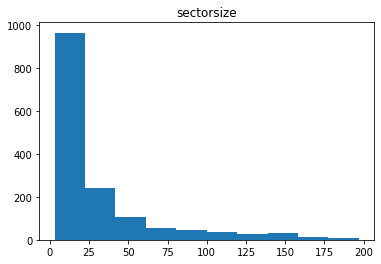

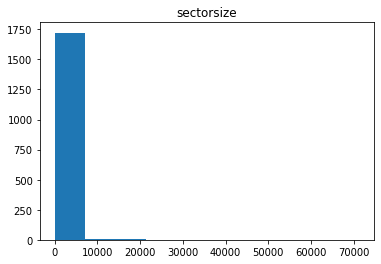

In [43]:
sectorsum = sectormat.sum(axis = 0)
plt.hist(sectorsum[sectorsum< 200].flat)
plt.title('sectorsize')
plt.show()

plt.hist(sectorsum.flat)
plt.title('sectorsize')
plt.show()

In [44]:
def gen_graphchunk(connectmat, start_node=None , niter = 3 , plotmat = True , verbose = False):
    #select random pt
    if start_node is None:
        start_node = random.randint(0,connectmat.shape[1])
    if verbose == True:
        print('starting at' , start_node )
        
    #convolvle w connectmat
    subgraph = None
    sizes = []
    for i in range(niter):
        if subgraph is not None:
            subgraph += connectmat.dot(subgraph)
           
            if plotmat == True and i%10 == 0:
                print(i)
                sizes.append(len(subgraph.nonzero()[0]) )
                plt.title( 'phylo tree connectivity matrix ' )
                plt.spy(subgraph, markersize= 1)
                plt.show()
            
        else:
            subgraph = scipy.sparse.coo_matrix(([1], ([start_node],[start_node])), shape=connectmat.shape)
            subgraph += connectmat.dot(subgraph)

    sumrow = subgraph.sum(axis = 1 )
    rows = np.where(  sumrow > 0 )
    
    if plotmat == True:
        print(rows)
        plt.title( 'phylo tree connectivity matrix ' )
        plt.spy(subgraph, markersize= 1)
        plt.show()
        plt.plot(sizes)
        plt.show()
    #find nonzero
    
    return rows[0]
#connectmat = sparse.COO(connectmat)

gen_subgraphs = False

if gen_subgraphs == True:
    nsamples = 1000
    graphsamples = [ gen_graphchunk(connectmat, niter = 35 , plotmat = False) for i in range(nsamples)]
    with open('graphsamples.pkl' , 'wb') as graphout:
        graphout.write(pickle.dumps(graphsamples))
else:
    with open('graphsamples.pkl' , 'rb') as graphout:
        graphsamples = pickle.loads( graphout.read() ) 
    

In [45]:
print(graphsamples[0])

[127288 127289 127290 ... 134156 134157 134164]


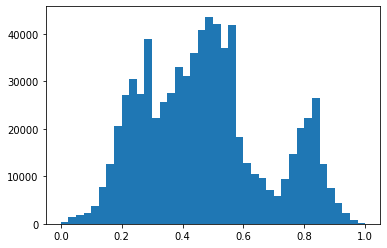

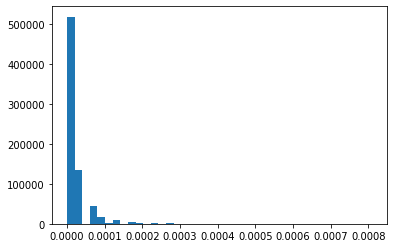

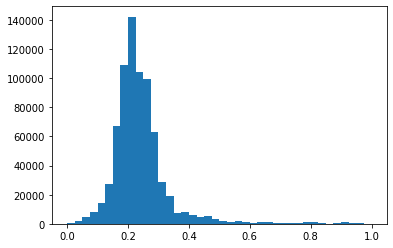

In [46]:
for i in range(template_features.shape[1]):
    plt.hist(np.array(template_features[:,i].data).flat, bins = 40)
    plt.show()

In [47]:
#get a hist of sector size

In [48]:
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)


2909.69140625


In [49]:
def ret_pytorch_sample(subfeatures, connect_up , connect_down , sub_diag ,  overview , overview_rev , intra , toss ):
    data = HeteroData()
    #add input data
    data['phylonodes_up'].x = torch.tensor( subfeatures )
    data['phylonodes_down'].x =torch.tensor( subfeatures )
    data['sectornode'].x =torch.tensor(  np.zeros((1,1)) )
    #up down fitch net
    data['phylonodes_up', 'phylolink_up', 'phylonodes_up'].edge_index = torch.tensor(connect_up ,  dtype=torch.long )
    data['phylonodes_down', 'phylolink_down', 'phylonodes_down'].edge_index = torch.tensor(connect_down ,  dtype=torch.long )             
    data['phylonodes_up', 'phylolink_up_down', 'phylonodes_down'].edge_index = torch.tensor( sub_diag ,  dtype=torch.long )
    data['phylonodes_down', 'phylolink_down_up', 'phylonodes_up'].edge_index = torch.tensor( sub_diag ,  dtype=torch.long )

    #pooling connections
    data['phylonodes_down', 'informs', 'sectornode'].edge_index = torch.tensor(overview ,  dtype=torch.long )
    data['phylonodes_up', 'informs', 'sectornode'].edge_index = torch.tensor(overview ,  dtype=torch.long )

    #pooling connections
    data['sectornode',  'informs', 'phylonodes_down' ].edge_index = torch.tensor(overview_rev,  dtype=torch.long )
    data['sectornode',  'informs', 'phylonodes_up'].edge_index = torch.tensor(overview_rev ,  dtype=torch.long )
    #categories are intra or interprotein contacts or nothing
    if intra == True:
        cateforical = np.array([0,1])
    else:
        cateforical = np.array([1,0])
    data['phylonodes_down'].y =torch.tensor( np.ones((subfeatures.shape[0],1) ) *toss ,  dtype=torch.long )
    data['phylonodes_up'].y =torch.tensor( np.ones((subfeatures.shape[0],1)) * toss ,  dtype=torch.long )
    #todo change to categorical
    data['sectornode'].y =torch.tensor(  np.ones((1,1))*toss  ,  dtype=torch.long )
    data = T.AddSelfLoops()(data)
    data = T.NormalizeFeatures()(data)
    return data

def yield_tosses(posi_percent = .5):
    while True:
        toss = scipy.stats.bernoulli.rvs(posi_percent, loc=0, size=1, random_state=None)
        yield toss

def gen_sample(toss , col1 , col2 , pairs, AA_tensor, NT_tensor, sectormat, connectmat_up, connectmat_down, connectmat_diag, 
    template_features , graphsamples , connectmat,  posi_percent = .5 , nsamples = 30 , min_nodes = 100,  q = None , iolock= None,  
    verbose = False, loop= True , sectors_chunk = True , intra = True , subsample = False ):
    
    #generate a few samples of subgraphs from a column pair
    label = np.ones((1,1))*toss

    #select coev features
    if verbose == True:
        print( 'col1',AA_tensor[:,col1,:] )
        print( 'col2', AA_tensor[:,col2,:] )
    nodeAAfeatures = sparse.stack( [AA_tensor[:,col1,:] ,AA_tensor[:,col2,:] ] , axis = 2  ).reshape((AA_tensor.shape[0],-1))
    nt_cols = []
    for pos in [0,1,2]: 
        nodeNTfeatures = sparse.stack( [NT_tensor[:,col1+ pos,:] ,NT_tensor[:, col2+ pos,:] ] , axis = 2)
        nt_cols.append(nodeNTfeatures.reshape((nodeNTfeatures.shape[0],-1)) )
    available_rows = list(np.where( nodeAAfeatures.sum(axis=1) > 0 )[0])
    if verbose == True:
        print(nodeAAfeatures)
        print(available_rows)
        
    features = [sparse.COO(template_features),nodeAAfeatures]+nt_cols
    features = [mat.to_scipy_sparse() for mat in features]
    nodefeatures = sparse.COO(scipy.sparse.hstack( features ))
    #slice the features into sectors and yield sectors
    samples =[]
    if subsample == True:
        while len( samples ) < nsamples:
            #select a row where the is at least 1 mutation
            rows = gen_graphchunk(connectmat, start_node=random.choice(available_rows) , niter = 10 , verbose = False, plotmat=False)
            if len(rows ) > min_nodes:
                #node features
                subfeatures = nodefeatures[rows,:].todense()
                #phylonode connections
                sub_connect_up = connectmat_up[rows,:]
                sub_connect_up = sub_connect_up[:,rows]
                connect_up = sparse2pairs(sub_connect_up)
                sub_connect_down = connectmat_down[rows,:]
                sub_connect_down = sub_connect_down[:,rows]
                connect_down = sparse2pairs(sub_connect_down)
                sub_diag = connectmat_diag[rows,:]
                sub_diag = sub_diag[:,rows]
                sub_diag = sparse2pairs(sub_diag)
                #aggregator node
                overview = scipy.sparse.lil_matrix( (subfeatures.shape[0], 2 ) )
                overview[:,0] = 1
                overview_rev = sparse2pairs(overview.T)
                overview = sparse2pairs(overview)
                data = ret_pytorch_sample(subfeatures, connect_up , connect_down , sub_diag ,  overview , overview_rev , intra , toss )
                samples.append(data)
    else:
        subfeatures = nodefeatures.todense()
        sub_connect_up = connectmat_up
        sub_connect_up = sub_connect_up
        connect_up = sparse2pairs(sub_connect_up)
        sub_connect_down = connectmat_down
        sub_connect_down = sub_connect_down
        connect_down = sparse2pairs(sub_connect_down)
        sub_diag = connectmat_diag
        sub_diag = sub_diag
        sub_diag = sparse2pairs(sub_diag)
        overview = scipy.sparse.lil_matrix( (subfeatures.shape[0], 2 ) )
        overview[:,0] = 1
        overview_rev = sparse2pairs(overview.T)
        overview = sparse2pairs(overview)
        data = ret_pytorch_sample(subfeatures, connect_up , connect_down , sub_diag ,  overview , overview_rev , intra , toss )
        samples = []
    return samples

def create_data_updown_transitions(client ,pairs, AA_tensor, NT_tensor, sectormat, connectmat_up, connectmat_down, connectmat_diag, 
 template_features , posi_percent = .5 , nsamples = 10 , min_nodes = 100,  q = None , iolock= None,  verbose = True, loop= True , sectors_chunk = True ):

    #map
    tossgen = yield_tosses(posi_percent)
    futures = client.map(
        
        gen_sample, tosses=tossgen , key=None, workers=None, retries=None, 
        resources=None, priority=0, allow_other_workers=False, fifo_timeout='100 ms', actor=False, 
        actors=False, pure=None, 
        batch_size= 10 ,                        
        
        #func args
        pairs= pairs , 
        AA_tensor= AA_tensor, 
        NT_tensor=NT_tensor,
        sectormat=sectormat,
        connectmat_up=connectmat_up,
        connectmat_down=connectmat_down,
        connectmat_diag=connectmat_diag,
        template_features=template_features,
        posi_percent = .5 , 
        nsamples = 10 , 
        min_nodes = 100,  
        q = None , 
        iolock= None,                   
        verbose = True, 
        loop= True ,
        sectors_chunk = True
         )
    
    #iterate over res as finished
    for future in as_completed(futures):
        samples = future.result()
        for data in samples:
            yield data
            
def check_pts(col, allcols):
    for i in range(30):
        if i+col in allcols:
            return i+col
        if -i+col in allcols:
            return -i+col
    else:
        return None
    
def create_data_updown_transitions_single( pairs, AA_tensor, NT_tensor, sectormat, connectmat_up, connectmat_down, connectmat_diag, 
    template_features , graphsamples, allcols, connectmat,  posi_percent = .5 , nsamples = 30 , min_nodes = 100,  q = None , iolock= None,  verbose = True, loop= True , sectors_chunk = True ):
    #map
    tossgen = yield_tosses(posi_percent)
    for toss in tossgen:
        if toss == 0:
            col1 = random.choice(allcols)
            col2 = col1
            while col1 == col2 and (col1,col2) not in pairs:
                col2 = random.choice(allcols)
            labels = np.zeros((template_features.shape[0],))           
        else:
            #positive sample
            pairindex = random.randint(0,pairs[0].shape[0])
            pairtuple = ( pairs[0][pairindex] , pairs[1][pairindex])
            while True:
                col1 = pairtuple[0]
                col1 = check_pts(col1, allcols)
                col2 = pairtuple[1]
                col2 = check_pts(col2, allcols)
                
                if col1 and col2 and col1!= col2:
                    break
                pairindex = random.randint(0,pairs[0].shape[0])
                pairtuple = ( pairs[0][pairindex] , pairs[1][pairindex])
        if verbose == True:
            print(toss)
            print(col1, col2)
        samples = gen_sample( toss , col1 , col2 ,  pairs, AA_tensor, NT_tensor, sectormat, connectmat_up, connectmat_down, connectmat_diag, template_features , graphsamples
        , connectmat , posi_percent = .5 ,  q = None , iolock= None,  verbose = verbose, loop= True  )
        #iterate over res as finishedsamples:
        for data in samples
            yield data

SyntaxError: invalid syntax (471365698.py, line 184)

In [ ]:
#create reduced alphabet mapping
#AA transitions

murphy12 = [('L','V','I','M'), ('C'), ('A'), ('G'), ('S','T'), ('P'), ('F','Y'), ('W'), ('E','Q'), ('D','N'), ('K','R'), ('H') ]
murphy12 = { c:i for i,cset in enumerate(murphy12) for c in cset   }
print('murphy12',murphy12)

ProteinAlphabet = [ 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y' ]
allowed_AA_transitions = [ c1+c2 for c1 in ProteinAlphabet for c2 in ProteinAlphabet  if c1!= c2]

print('ntransitions' ,len(set(allowed_AA_transitions)))
new_transitions = [ (murphy12[c1],murphy12[c2]) for c1 in ProteinAlphabet for c2 in ProteinAlphabet  if c1!= c2  ]
new_transitions = { tup:i for i,tup in enumerate(set(new_transitions)) }
print('nmurphy transitions' , len(set(new_transitions)))
print(allowed_AA_transitions[0:100] , '...etc...')
transitiondict_AA = {  c : i  for i,c in enumerate( allowed_AA_transitions )  }
rev_transitiondict_AA = dict( zip(transitiondict_AA.values(), transitiondict_AA.keys()))


In [ ]:
print(pairs[0].shape)

In [ ]:

#reduce alphabet to reduce AA transition dimensionality
def restrictAA_transitions(AAmat, rev_transitiondict_AA, murphy12 , new_transitions , restricted_transitions = 138 , verbose = True ):
    restricted = None
    for z in range(AAmat.shape[2]):
        
        transition = rev_transitiondict_AA[z]
        new_transition = new_transitions[ (murphy12[transition[0]] , murphy12[transition[1]] )]
        data = AAmat[:,:,z].data
        coords =  AAmat[:,:,z].coords
        if coords.shape[1]>0:    
            newcoords = np.vstack( [coords, np.ones((1,coords.shape[1]))*new_transition]).astype('int')
            if restricted is not None:
                restricted  += sparse.COO( coords =  newcoords , data = data
                                            , shape = (AAmat.shape[0] , AAmat.shape[1] , restricted_transitions )  )
            else:
                restricted  =  sparse.COO( coords = newcoords , data = data  
                                            , shape = (AAmat.shape[0] , AAmat.shape[1] , restricted_transitions )  )
    return restricted


In [ ]:
###rewrite codon compilation for sparse
import sparse

restrictAA = False
collapseMats = True
buildstructmats = False

if buildstructmats == True:
    def retcodons( AAmat , NTmat, qstart, qend, verbose = True ):
        #aa mutations for each pos
        AAmat_sub = sparse.stack(  [ AAmat[ : , codon:codon+2 , : ].sum(axis = 1) for codon in range(qstart-1, qend-1 , 3 )  ] , axis = 1 )    
        #add the frames for each in a stack 
        if verbose == True:
            print('done AA')
        NTmat_sub = sparse.stack([  sparse.stack( [ NTmat[:, codon + frame , : ] for frame in [0,1,2] ] , axis = 1 )  for codon in range(qstart-1, qend-1 , 3 ) ] , axis = 1)
        if verbose == True:
            print('done NT')
        return AAmat_sub , NTmat_sub
    print(annotation)
    structmats = {}
    start_stop ={}
    print(nucleotide_mutation)
    print(AA_mutation)

    for i,row  in annotation.iterrows():
        print(row.qstart)
        if row.struct not in structmats:
            structmats[row.struct]={}    
        if (row.qstart , row.qend) not in start_stop:
            structmats[row.struct][row.chain ] = retcodons(AA_mutation, nucleotide_mutation  , row.qstart , row.qend)
            if restrictAA == True:
                structmats[row.struct][row.chain ] = ( restrictAA_transitions(structmats[row.struct][row.chain ][0] , rev_transitiondict_AA, murphy12 , new_transitions , restricted_transitions = 138 ) , structmats[row.struct][row.chain ][1] )
            elif collapseMats == True:
                endshapeAA = list(structmats[row.struct][row.chain ][0].shape)
                endshapeAA[2] = 1
                
                endshapeNT = list(structmats[row.struct][row.chain ][1].shape)
                endshapeNT[3] = 1
                
                
                structmats[row.struct][row.chain ] = ( structmats[row.struct][row.chain ][0].sum(axis = 2).reshape(endshapeAA) , structmats[row.struct][row.chain ][1].sum(axis = 3).reshape(endshapeNT) )

            
            start_stop[(row.qstart , row.qend)] = structmats[row.struct ][ row.chain ]
        else: 
            structmats[row.struct][row.chain ] = start_stop[(row.qstart , row.qend)]
    with open('structmats.pkl' , 'wb') as structout:
        structout.write( pickle.dumps( structmats ))
else:
    with open('structmats.pkl' , 'rb') as structout:
        structmats= pickle.loads(  structout.read())

In [ ]:
#looking for more than 1 position
submat = structmats['7DZW']['C'][0]

submat = submat.sum(axis = 2)
allcols = list(np.where( submat.sum(axis = 0 ) > 10 )[0])
print(len(set(allcols)))

In [ ]:
print(structmats)

In [ ]:
template_features = sparse.COO(template_features)
sampleGEN = create_data_updown_transitions_single( pairs, structmats['7DZW']['C'][0] , structmats['7DZW']['C'][1] , sectormat, connectmat_up, connectmat_down, connectmat_diag, 
 template_features ,graphsamples, allcols, connectmat, posi_percent = .5 , nsamples = 10 , min_nodes = 100,  q = None , iolock= None,  verbose = False, loop= True , sectors_chunk = True )

In [ ]:
data = next( sampleGEN )
print(data)

In [ ]:
testsamples = []
reload = True
calc_samples = True

if reload == True:
    with open('testsamples.pkl' , 'rb') as sampleout:
        testsamples =  pickle.loads(sampleout.read())
        

In [ ]:
if calc_samples == True:
    for i in range(500):
        testsamples.append(next(sampleGEN)) 
        if i % 10 == 0:
            print(i, len(testsamples) ) 
            with open('testsamples.pkl' , 'wb') as sampleout:
                sampleout.write(pickle.dumps(testsamples))


In [ ]:
samples = []

if reload == True:
    with open('trainsamples.pkl' , 'rb') as sampleout:
        samples =  pickle.loads(sampleout.read())

In [ ]:
if calc_samples == True:
    for i in range(500):
        samples.append(next(sampleGEN)) 
        if i % 10 == 0:
            print(i, len(samples) ) 
            with open('trainsamples.pkl' , 'wb') as sampleout:
                sampleout.write(pickle.dumps(samples))

In [ ]:
print( next( sampleGEN ))

In [ ]:
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)


In [ ]:
print(structmats)

In [ ]:
print(subthresh_connected['7DZW'])

In [65]:
from torch_geometric.nn import HeteroConv , SAGEConv, Linear , ResGatedGraphConv , GATv2Conv , TransformerConv , MFConv , FiLMConv 
import torch_geometric.transforms as T
#"sum", "mean", "min", "max"
#without sectornode
class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_layers):
        super().__init__()
        
        self.convs = torch.nn.ModuleList()
        self.lins =  torch.nn.ModuleList()
        self.lins2 =  torch.nn.ModuleList()
        
        for i in range(num_layers):
            conv = HeteroConv({
                ('phylonodes_up', 'phylolink_up', 'phylonodes_up'):SAGEConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_down', 'phylolink_down', 'phylonodes_down'):SAGEConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_down', 'phylolink_down_up', 'phylonodes_up'):SAGEConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_up', 'phylolink_up_down', 'phylonodes_down'):SAGEConv((-1,-1),  int( hidden_channels) ), 
                ('phylonodes_down', 'informs', 'sectornode'):SAGEConv((-1,-1),  int( hidden_channels) ),
                ('phylonodes_up', 'informs', 'sectornode'):SAGEConv((-1,-1),  int( hidden_channels) ),
                ('sectornode', 'informs', 'phylonodes_down'):SAGEConv((-1,-1),  int( hidden_channels) ),
                ('sectornode', 'informs', 'phylonodes_up'):SAGEConv((-1,-1),  int( hidden_channels) ),
            } , aggr='sum')
            self.convs.append(conv)
            for vectype in  ['phylonodes_up', 'phylonodes_down' , 'sectornode'  ]:
                lin1 = Linear(-1 , int( hidden_channels))
                self.lins.append( lin1 )
                
            print( 'hidden units' , int( hidden_channels) )
            print( 'layer' , i )

        for vectype in ['phylonodes_up', 'phylonodes_down' , 'sectornode' ]:
            lin2 = Linear(-1 , out_channels)
            self.lins2.append( lin2 ) 

    
    def forward(self, x_dict, edge_index_dict):
        lins = iter(self.lins)
        for i,conv in enumerate(self.convs):
            x_dict = conv(x_dict , edge_index_dict)
            x_dict = {key:( F.dropout(x , p = .1 , training = self.training ) if 'phylo' in key else x ) for key, x in x_dict.items()}

            for key, x in x_dict.items():
                x_dict[key] = next(lins)(x)
        lins2 = iter(self.lins2)
        
        for key, x in x_dict.items():
            x_dict[key] =  next(lins2)(x)
        return {key: F.tanh(x) for key, x in x_dict.items()}
        #return x_dict

model = HeteroGCN(hidden_channels= 20 , out_channels=1, num_layers=4)
model = model.double()
model = model.to(device)


hidden units 20
layer 0
hidden units 20
layer 1
hidden units 20
layer 2
hidden units 20
layer 3


In [74]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=10**-5)
with torch.no_grad():  # Initialize lazy modules.
    data = data.to(device)
    out = model(data.x_dict , data.edge_index_dict)

In [75]:
import warnings
from torch_geometric.loader import DataLoader



lastauc = 0
epochs = 1000
#iterate over structs
model = model.to(device)
calc_metrics_overds = True
def calc_metrics(truths,preds,label = ''):
    truth = np.hstack(truths).ravel()
    predy = np.hstack(preds).ravel()
    fpr, tpr, _ = roc_curve(  truth  ,predy )
    auc_s = auc(fpr, tpr)
    print(label,auc_s)

"""     
with warnings.catch_warnings():
    model.train()
    warnings.simplefilter("ignore")
    #iterate over chain pairs
    #create a chunk generator for a chain pair
    #iterate over graph chunks
    for struct in subthresh_connected:
        for i,chains in enumerate(subthresh_connected[struct]):
            
"""            



#AA_tensor , NT_tensor = structmats[struct][chains]
#intra = len(chains)>1
#pairs = list(allpairs[struct][chains])

#dask parallel gen of data on the fly

#sampleGEN = create_data_updown_transitions_single( pairs, structmats[struct][chains][0] , structmats[struct][chains][1] , sectormat, connectmat_up, connectmat_down, connectmat_diag, 
#template_features , posi_percent = .5 , nsamples = 10 , min_nodes = 100,  q = None , iolock= None,  verbose = False, loop= True , sectors_chunk = True )
#sampleGEN = create_data_updown_transitions_single(  pairs, structmats[struct][chains][0] , structmats[struct][chains][1] , sectormat, connectmat_up, connectmat_down, connectmat_diag, 
#template_features ,graphsamples, posi_percent = .5 , nsamples = 100 , min_nodes = 100,  q = None , iolock= None,  verbose = False, loop= True , sectors_chunk = True )

#sampleGEN = create_data_updown_transitions_single( pairs, structmats['7DZW']['C'][0] , structmats['7DZW']['C'][1] , sectormat, connectmat_up, connectmat_down, connectmat_diag, 
#template_features ,graphsamples, allcols, posi_percent = .5 , nsamples = 100 , min_nodes = 100,  q = None , iolock= None,  verbose = False, loop= True , sectors_chunk = True )


print('done init')
truths = []
preds = []

truths_n = []
preds_n = []

losses1 =[]
losses2 = []
losses3 = []
testloader = DataLoader(testsamples, batch_size=10)
loader = DataLoader(samples, batch_size=10)
for epoch in range(epochs):
    for k,data in enumerate(loader):
        if k % 200 == 0 :
            print('losses', np.mean(losses1), np.mean(losses2), np.mean(losses3) )
            losses1 = []
            losses2 = []
            losses3 = []
            
            if calc_metrics_overds == True and k > 0 and k%200 == 0:
                print('metrics')
                model.eval()
                truths = []
                preds = []
                truths_n = []
                preds_n = []
                for testdata in testloader:
                    testdata = testdata.to(device)
                    pred = model(testdata.x_dict ,testdata.edge_index_dict)
                    truth = testdata['sectornode']['y'][:,0].to('cpu').detach().numpy()
                    predy =  pred['sectornode'][:,0].to('cpu').detach().numpy()
                    truths.append(truth)
                    preds.append(predy)
                    
                    truth_n = testdata['phylonodes_down']['y'][:,0].to('cpu').detach().numpy()
                    pred_n =  pred['phylonodes_down'][:,0].to('cpu').detach().numpy()
                    truths_n.append(truth_n)
                    preds_n.append(pred_n)
                calc_metrics(truths,preds,label = 'sectornode')
                calc_metrics(truths_n,preds_n,label = 'phylonodes')     
                
        data = data.to(device)            
        out = model(data.x_dict ,data.edge_index_dict)
        optimizer.zero_grad()
        loss1 =  F.mse_loss(out['phylonodes_up'], data['phylonodes_up'].y.double())
        loss2 =  F.mse_loss(out['phylonodes_down'], data['phylonodes_down'].y.double())
        loss3 =  F.mse_loss(out['sectornode'], data['sectornode'].y.double())

        loss = loss1 + loss2 + loss3
        loss.backward()
        optimizer.step()
        losses3.append(float(loss3.to('cpu')))
        losses2.append(float(loss2.to('cpu')))
        losses1.append(float(loss1.to('cpu')))


done init
losses nan nan nan


/users/dmoi/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/users/dmoi/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


losses 0.34682407378571 0.347250981374881 0.32290783030046954
metrics
sectornode 0.44166666666666665
phylonodes 0.4971185586747445


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.2738576479172714 0.27096991874144366 0.26443861281169584
losses 0.25433500163520817 0.2529561487968375 0.2529544378854819
metrics
sectornode 0.448586387434555
phylonodes 0.498050573862397


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.2590891604521069 0.25725010725570874 0.25638616441859907
losses 0.2541784957948072 0.25260610174561904 0.2522091437351536
metrics
sectornode 0.5127835951134381
phylonodes 0.4985223256811882


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.257074853219818 0.25559919553056465 0.25501684808865266
losses 0.253430462510223 0.25185593904035797 0.2516456877047774
metrics
sectornode 0.5468935427574171
phylonodes 0.49857431680004444


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.25634852288118065 0.25506522310233654 0.2544777701801786
losses 0.2529062077536393 0.2514084477131629 0.25132586454150185
metrics
sectornode 0.5491361256544502
phylonodes 0.49843166425795804


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.2560012675067792 0.2548594354801628 0.2541868197780331
losses 0.25252561330780454 0.25111418376746175 0.25110248321455364
metrics
sectornode 0.5461343804537522
phylonodes 0.49812742894794604


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.2558021644280261 0.2547817453457661 0.25398933819400427
losses 0.25223744586750996 0.2508977134086108 0.2509267246719111
metrics
sectornode 0.5459860383944153
phylonodes 0.4978055746484137


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.25567814004987527 0.2547640615100689 0.25382849065442586
losses 0.25200851280150893 0.25072957294163245 0.25078072230865556
metrics
sectornode 0.5464223385689354
phylonodes 0.4975138985288261


/work/FAC/FBM/DBC/cdessim2/default/dmoi/condaenvs/envs/ML2/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


losses 0.25560288246993623 0.25478042574158805 0.2536830986969015


KeyboardInterrupt: 

In [ ]:
         
        
        '''
        truths = []
        preds = []
        losses3 = []
        for i,data in enumerate(trainloader):
            data = data.to(device)
            out = model(data.x_dict ,data.edge_index_dict)
            optimizer.zero_grad()

            loss3 =  F.smooth_l1_loss(out['godnode'].double(), data['godnode'].y.double())
            loss = loss3
            loss.backward()
            optimizer.step()
            losses3.append(float(loss3.to('cpu')))
            truth = data['sectornode']['y'][:,0].to('cpu').detach().numpy()
            predy =  out['sectornode'][:,0].to('cpu').detach().numpy()
            truths.append(truth)
            preds.append(predy)


        truth = np.hstack(truths)
        predy = np.hstack(preds)
        fpr, tpr, _ = roc_curve(  truth  ,predy )
        auc_n = auc(fpr, tpr)
        print('losses', np.mean(losses1), np.mean(losses2), np.mean(losses3) )
        print('train auc', auc_n)
        
        
        model.eval()

        
        truths = []
        preds = []

        truths_n = []
        preds_n = []
        
        
        for i,testdata in enumerate(testloader):
            testdata = testdata.to(device)
            pred = model(testdata.x_dict ,testdata.edge_index_dict)
            truth = testdata['godnode']['y'][:,0].to('cpu').detach().numpy()
            predy =  pred['godnode'][:,0].to('cpu').detach().numpy()
            truths.append(truth)
            preds.append(predy)

            truth_n = testdata['phylonodes_down']['y'][:,0].to('cpu').detach().numpy()
            pred_n =  pred['phylonodes_down'][:,0].to('cpu').detach().numpy()

            truths_n.append(truth_n)
            preds_n.append(pred_n)

        truth = np.hstack(truths)
        predy = np.hstack(preds)
        fpr, tpr, _ = roc_curve(  truth  ,predy )
        auc_gn = auc(fpr, tpr)
        print('test auc',auc_gn)
        truth_n = np.hstack(truths_n)
        predy_n = np.hstack(preds_n)

        fpr, tpr, _ = roc_curve(  truth_n  ,predy_n )
        auc_n = auc(fpr, tpr)        
        print('test node auc',auc_n)
        if auc_gn > lastauc:
            lastauc = auc_gn
            print('saving')
            torch.save(model, './phylographnet_job_final50.torch')
            print('done')
        '''
        

In [ ]:
        #load subgraphs
        #train_input_nodes = #######
        #train_loader = HGTLoader(data , num_samples=[1024] * 4, shuffle=True, input_nodes=train_input_nodes, **kwargs)
        #for trainsample in train_loader:
            #train here
            
            
            
    #for labels in [ aglo_l]:
    #    l,c = np.unique(labels, return_counts= True)
        print(i)
        print(chain)
        #categorical-> direct, indirect or no contact
        
        
        
        
        
        
        if i == 0 :
            total_thresh = subthresh_thresh['7DZW'][chain]
            total_connect = subthresh_connected['7DZW'][chain]

            #green, oranges, reds = struct_hits( labels, threshmat , connectmat , struct = '7DZW' , chain=chain , l=l , c=c , verbose = False , radius = 10)
        else:
            total_thresh += subthresh_thresh['7DZW'][chain]
            total_connect += subthresh_connected['7DZW'][chain]
            
        # find nonzero
        # zeroed entries are the complement
        #sample each fraction randomly
        ### testing loop ####
        if epoch % 100 == 0:
            ROC_curve_single(y_test, y_pred_grd)
        
        ### save based on performance
        
        
            
proj_greens, proj_oranges, proj_reds = struct_hits_filter( AATF, labels, total_thresh , total_connect , struct = '7DZW' , chain=chain , l=l , c=c , verbose = False , radius = 10 )
#proj_greens, proj_oranges, proj_reds = struct_hits(  labels, total_thresh , total_connect , struct = '7DZW' , chain=chain , l=l , c=c , verbose = False , radius = 10 )

print(proj_greens, proj_oranges, proj_reds )

In [ ]:
#use for lsh encoding
def retcodon_mats(annotation , AAmat , plt = False):
    positions = set([])
    AAmat = scipy.sparse.csc_matrix(AAmat)
    print('converted')
    slices = []
    for i,r in annotation.iterrows():
        if (r.qstart-1, r.qend-1) not in slices:        
            slices.append((r.qstart-1, r.qend-1))
    count = 0
    for start,end in slices:
        codonmat = np.zeros(( AAmat.shape[0] , int((end - start + 10 ) /3) ) )
        for j,codon in enumerate(range(start-1, end-1 , 3 )):
            cols = np.sum( AAmat[:, codon:codon+2] , axis = 1 )
            codonmat[:,count] = cols.ravel()
            count+=1
            if count%500 == 0 and count >0:
                print(count/codonmat.shape[1])
        yield codonmat 
        
        if plt == True:
            print(np.sum(codonmat))
            plt.figure(figsize=(20,20))
            plt.spy(codonmat, markersize= .5)
            plt.show()

In [51]:
from datasketch import MinHashLSHForest, WeightedMinHash , MinHash
#Ntaxa known. avoid allvsall
from datasketch import WeightedMinHashGenerator
import dask.array as da 
# WeightedMinHashGenerator requires dimension as the first argument
#flatten aa mat
print('flatten matrix ' ) 
AA_mat = AA_mutation.sum(axis = 2).to_scipy_sparse()
print('done' )

def blur_cols( mat , blurmat , niter = 10 , distributed = True ):
    for i in range(niter):
        print(i)
        mat += blurmat.dot(mat)
    return mat


#transform dask array
#AAmat_dask = da.from_array(AA_mat)
#blurmat = da.from_array(connectmat)
print('blurring')
mat = blur_cols(AA_mat, connectmat, 10 )
print(mat)

indices = np.where( mat.sum(axis = 0 ) )


flatten matrix 
done
blurring
0
1
2
3
4
5
6
7
8
9
  (0, 25698)	1.0
  (0, 25701)	1.0
  (0, 25704)	1.0
  (0, 25707)	1.0
  (2, 7795)	1.0
  (2, 7798)	1.0
  (2, 7801)	1.0
  (2, 7804)	1.0
  (2, 25914)	1.0
  (2, 25917)	1.0
  (2, 25920)	1.0
  (2, 25923)	1.0
  (2, 25707)	20.0
  (2, 25704)	20.0
  (2, 25701)	20.0
  (2, 25698)	20.0
  (3, 25698)	1.0
  (3, 25701)	1.0
  (3, 25704)	1.0
  (3, 25707)	1.0
  (4, 25698)	1.0
  (4, 25701)	1.0
  (4, 25704)	1.0
  (4, 25707)	1.0
  (5, 25698)	1.0
  :	:
  (741317, 5767)	1.0
  (741322, 12805)	1.0
  (741322, 12808)	1.0
  (741322, 12811)	1.0
  (741322, 12814)	1.0
  (741322, 5767)	20.0
  (741322, 5764)	20.0
  (741322, 5761)	20.0
  (741322, 5758)	20.0
  (741323, 12805)	197.0
  (741323, 12808)	197.0
  (741323, 12811)	197.0
  (741323, 12814)	197.0
  (741323, 5767)	20404.0
  (741323, 5764)	20404.0
  (741323, 5761)	20404.0
  (741323, 5758)	20404.0
  (741324, 5758)	5822.0
  (741324, 5761)	5822.0
  (741324, 5764)	5822.0
  (741324, 5767)	5822.0
  (741325, 5758)	197.0
  (7413

In [117]:
print('generating mh functions' )
wmg = WeightedMinHashGenerator(mat.shape[0] , sample_size=256 , seed=0)
print('done')

generating mh functions
done


In [118]:
import time

print(indices )
print(len(indices[0]))
print(mat[:,indices[1][0]].nonzero()[0])
print(len(mat[:,indices[1][0]].nonzero()[0]))

(array([0, 0, 0, ..., 0, 0, 0]), array([  277,   280,   283, ..., 29632, 29635, 29638]))
7692
[ 69773  69774  69775  69776  69777  69778  69779  69780  69781  69782
  69783  69784  69785  69786  69787  69788  69789  69790  69791  69798
  69801  69802  69803  69804  69805  69806  69807  69808  69809  69810
  69811  69812  69813  69814  69815  69816  69817  69818  69819  69820
  69821  69822  69823  69824  69825  69826  69827  69828  69829  69830
  69831  69832  69833  69834  69835  69836  69837  69838  69839  69840
  69841  69842  69843  69844  69845  69846  69847  69848  69849  69850
  69851  69852  69853  69854  69855  69856  69857  69858  69859  69860
  69861  69862  69863  69864  69865  69874  69886  69887  69888  69889
  69890  69891  69892  69893  69894  69921  70002  70003  70004  70079
  70145  70146  70156  70161  70162  71048  71390 102412 102413 102414
 102417 102418 102419 102420 102421 102422 102423 102424 102425 102426
 102427 102428 102429 102430 102431 102432 102433 1024

In [119]:
start = time.time()
mh = MinHash()
mat = sparse.COO(mat)
[mh.update(e) for e in list( mat[:,indices[1][0]].nonzero()[0] ) ]
print( start - time.time())
print(mh.digest())

-0.6882634162902832
[  254175  3629290   421593  1014073  1062925  2545171  4167147  1950652
  4189894   257996  3402866  2420885  4242687   660865  6664433  5187024
  4165306 16486316   381899  1519656  1223264  6720951  4302529  3993195
  4186127  5249378  1586628  2088311  7843029 11540065  4655344  5973330
 11983903   725488  4177427  1739152   357099  1119858  1794051 13715492
 16489441  1494949    67248  7034841   574124   184359   759296  1610558
  1692745  6983273   182454  2602904  1321049  8167251  1178962 14637378
  4696408   752689  4513026  1491951  3554374  7598953  1428714   190310
  3289838  4760927  1574379  2664266  4647833 10763728   337175  4584817
  2534763 16904191  7765745  5409804  2784604  2139462   113078  1966514
 12753946 13681822  7225071  3886613   832857  7292117 10106646  5292553
  1681554   156643  2381203   640211 15881053  5562664  1797190  3640551
  2524800 10173298  1442796  8004906  2200891   694003 10069900  8601972
  1663451 18648983   611164  39

In [154]:
import h5py
import multiprocessing as mp
#@dask.delayed()
def hash_cols( col ):
    nz = col.nonzero()[0]
    mh = MinHash(num_perm=256 , seed = 0 )
    [mh.update(e) for e in list( nz ) ]
    return mh
print('strating pool')
pool = mp.Pool()
print('done')

batch = 10
res = []
thiscols = []
forest = MinHashLSHForest(num_perm=256)

print('starting')
mapper = {}
revmapper = {}
count = 0
with h5py.File("hashsigs.hdf5", "w") as f:
    dset = f.create_dataset("signatures", maxshape = (None, 256), shape=(len(list(indices[1])) ,256) , dtype='int64')
    print('created dataset')
    for i,col in enumerate(list(indices[1])):
        if i % 100 == 0:
            print(i)
        res.append( pool.apply_async(hash_cols ,[ mat[:,col] ] ) )
        thiscols.append(col)
        if len(res)> batch :
            res = [ r.get() for r in res ]
            for n,col in enumerate(res):
                forest.add(thiscols[n], res[n])
                if dset.shape[0]< count-1:
                    dset.resize((count+10 ,256 ))  
                    print(dset.shape)
                dset[count,:] = res[n].digest()
                mapper[count] = thiscols[n]
                revmapper[ thiscols[n] ] =count 
                count +=1
                f.flush()
                
            res = []
            thiscols = []
    print(dset,dset[0:10],f)
pool.close()





with open('lshforest.pkl' , 'wb') as forestout:
    forestout.write(pickle.dumps(forest))
    

strating pool
done
starting
created dataset
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
<HDF5 dataset "signatures": shape (7692, 256), type "<i8"> [[ 2494675  4349527  1453249 ...  1336616  4051722  3860093]
 [ 2494675  4349527  1453249 ...  1336616  4051722  3860093]
 [ 2494675  4349527  1453249 ...  1336616  4051722  3860093]
 ...
 [ 2697362  4733471  3831971 ...  5947069 12769912  1833204]
 [ 4307524  2213986  8045764 ...   712233    74882  1814831]
 [ 4307524  2213986  8045764 ...   712233    74882  1814831]] <HDF5 file "hashsigs.hdf5" (mode r+)>


In [53]:
with open('lshforest.pkl' , 'rb') as forestout:
    forest = pickle.loads(forestout.read())
    
forest.index()

mapper = {}
for i,col in enumerate(list(indices[1])):
    mapper[i]= col
revmapper = dict( zip( mapper.values(), mapper.keys()))

In [86]:
#create a net of columns

#pull hash
def col2hash( revmap , col):
    with h5py.File("hashsigs.hdf5", "r") as f:
        return MinHash(seed=0,hashvalues=f['signatures'][revmap[col],:])
def query2distances(qcol,revmapper, forest , k = 20 ):
    qhash = col2hash( revmapper , qcol)
    rescols = forest.query(qhash , k = k )
    mhs = [ col2hash(revmapper,col) for col in rescols ]
    jaccards = np.array([ qhash.jaccard( mh ) for mh in mhs ])
    #sort results
    order = np.flip(np.argsort(jaccards))
    rescols = np.array(rescols)[order]
    jaccards = jaccards[order]
    return rescols, jaccards

def build_net(cols,revmapper, forest , matshape = (30000, 30000)):
    connectmat = scipy.sparse.lil_matrix(matshape)
    cols = list(cols)
    for i,qcol in enumerate(cols):
        if i % 100 == 0 :
            print(i)
        rescol, jaccards = query2distances(qcol,revmapper, forest , k = 10 )
        connectmat[qcol,rescol] += jaccards
    connectmat+= connectmat.T
    connectmat/=2
    return scipy.sparse.coo_matrix(connectmat)



def sample_random(cols , nsamples , revmapper):
    samples = []
    cols = list(cols)
    for i in range(nsamples):
        col1 = random.choice(cols)
        col2 = random.choice(cols)
        mh1 = col2hash(revmapper , col1)
        mh2 = col2hash(revmapper , col2)
        samples.append(mh1.jaccard(mh2) )
    
    from scipy.stats import weibull_min
    fig, ax = plt.subplots(1, 1)
    x,c,loc = weibull_min.fit(samples)
    print(x,c,loc)
    
    x = np.linspace(weibull_min.ppf(x,c,loc),
                weibull_min.ppf(x,c,loc), 100)
    ax.plot(x, weibull_min.pdf(x, c, loc),
       'r-', lw=5, alpha=0.6, label='weibull_min pdf')
    
    ax.hist(samples, density=True, histtype='stepfilled', alpha=0.2)

    #fit weibull
    
    
    return distribution

qcol = indices[1][850]
print(qcol)

#wb = sample_random(indices[1] , 1000 , revmapper)
mh = col2hash( revmapper, qcol) 
jaccard_connectmat = build_net(indices[1], revmapper, forest ,matshape = (30000, 30000))

res = forest.query(mh, k = 10 )
print(res)
rescols, jaccards = query2distances(qcol,revmapper, forest , k = 10 )

print(rescols , jaccards )

#query for k NN

#thresh based on jaccard distribution


#

2764
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
[2758, 9928, 2761, 9931, 2764, 9934, 2767, 9937]
[2767 2764 2761 2758 9937 9934 9931 9928] [1.         1.         1.         1.         0.01953125 0.01953125
 0.01953125 0.01953125]


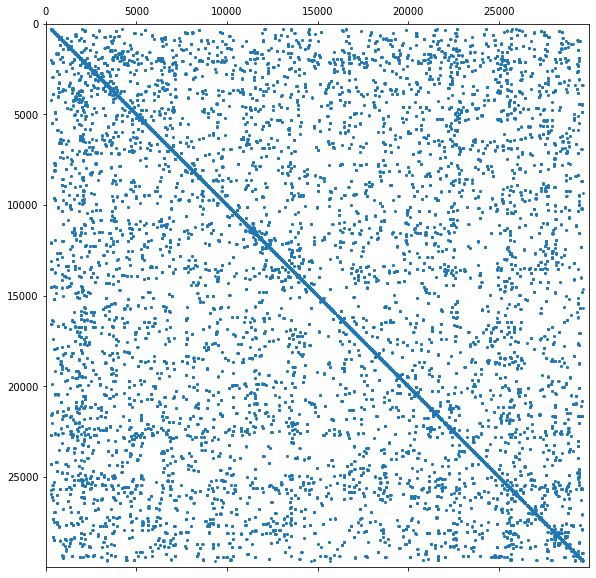

In [92]:
thresh = .25
plt.figure(figsize= (10,10) )
plt.spy( jaccard_connectmat , markersize= 1)
plt.show()

In [ ]:
row = annotation.iloc[0]
print(row)
submat = jaccard_connectmat[row.qstart:row.qend,:]
submat = jaccard_connectmat[:,row.qstart:row.qend]
plt.figure(figsize= (10,10) )
plt.spy( jaccard_connectmat , markersize= 1)
plt.show()

In [ ]:

#check contact pts ROC w jaccard

#


In [ ]:
import networkx as nx



In [ ]:
#cosntruct graph of cols

#ML on retpairs